In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Reading the dataset &   2. Choosing headphones & 3. Total Rows

In [26]:
import pandas as pd
import gzip
import json
import csv
import io
import os


reviews_path = '/content/drive/MyDrive/IR/ass3/Electronics_5.json.gz'
metadata_path = '/content/drive/MyDrive/IR/ass3/meta_Electronics.json.gz'
product_keyword = 'Headphones'


def parse_metadata(filepath, columns):
    data = []
    with gzip.open(filepath, 'rt', encoding='utf-8') as f:
        for line in f:
            obj = json.loads(line)
            filtered_obj = {col: obj.get(col) for col in columns}
            data.append(filtered_obj)
    return data

def load_and_process_in_chunks(reviews_path, metadata_path, product_keyword):
    chunk_size = 10000
    list_of_filtered_chunks = []
    total_rows_before_cleaning = 0
    total_duplicates_removed = 0

    metadata_columns = ['asin', 'title', 'brand', 'categories']
    metadata_df = pd.DataFrame.from_records(parse_metadata(metadata_path, metadata_columns))

    for chunk in pd.read_json(reviews_path, lines=True, chunksize=chunk_size, compression='gzip'):
        # Initial count before any cleaning
        total_rows_before_cleaning += chunk.shape[0]

        # Preprocessing
        chunk['reviewText'] = chunk['reviewText'].astype(str).str.lower().str.replace(r"[^a-zA-Z\s]", "", regex=True)
        chunk['summary'] = chunk['summary'].astype(str).str.lower()
        filtered_chunk = chunk[chunk['reviewText'].str.contains(product_keyword, case=False)]

        # Explicitly copy the filtered chunk to avoid SettingWithCopyWarning
        filtered_chunk = filtered_chunk.copy()

        # Drop rows with missing values in 'reviewText' or 'summary'
        filtered_chunk.dropna(subset=['reviewText', 'summary'], inplace=True)

        # Remove duplicates
        before_removal = filtered_chunk.shape[0]
        filtered_chunk = filtered_chunk.drop_duplicates(subset=['reviewerID', 'reviewText'])
        after_removal = filtered_chunk.shape[0]
        total_duplicates_removed += (before_removal - after_removal)

        # Merge with metadata
        if not filtered_chunk.empty:
            filtered_chunk = pd.merge(filtered_chunk, metadata_df, on='asin', how='left')
            list_of_filtered_chunks.append(filtered_chunk)

    final_df = pd.concat(list_of_filtered_chunks, ignore_index=True) if list_of_filtered_chunks else pd.DataFrame()

    print(f"Total number of rows (reviews) before cleaning: {total_rows_before_cleaning}")
    print(f"Removed {total_duplicates_removed} duplicate rows. Total rows after cleaning: {final_df.shape[0]}")

    return final_df


# Load and process the data
final_df = load_and_process_in_chunks(reviews_path, metadata_path, product_keyword)
print(final_df.head())
final_df_copy = final_df.copy()


Total number of rows (reviews) before cleaning: 6739590
Removed 490 duplicate rows. Total rows after cleaning: 185982
   overall  vote  verified   reviewTime      reviewerID        asin style  \
0        5  13.0     False  11 19, 2013  A2WFBRX9R0D84U  1400501741   NaN   
1        4  25.0     False  05 30, 2010   A4WCZVA328QB4  1400599997   NaN   
2        5  97.0     False  06 26, 2013  A3PD8JD9L4WEII  1400699169   NaN   
3        4   3.0     False  09 25, 2013   A3ODENXA668OR  1400501466   NaN   
4        3   3.0     False   12 1, 2012  A3PIPAS3M7YLQC  1400501466   NaN   

        reviewerName                                         reviewText  \
0    Amazon Customer  the nook hd  is an amazing device for the pric...   
1  Allen D. Reinecke  update   bn is offering a  gift card with ever...   
2               Bron  review for barnes  noble nook hd\n\na new winn...   
3        DarthAurora  i got the nook tablet for christmas last year ...   
4             Stuart  i own the original noo

# 4. Descriptive Stats

In [4]:
#a. Number of Reviews
number_of_reviews = final_df.shape[0]
print(f"Number of Reviews: {number_of_reviews}")

#b. Average Rating Score
average_rating_score = final_df['overall'].mean()
print(f"Average Rating Score: {average_rating_score:.2f}")

#c. Number of Unique Products
number_of_unique_products = final_df['asin'].nunique()
print(f"Number of Unique Products: {number_of_unique_products}")

#d. Number of Good Ratings
number_of_good_ratings = final_df[final_df['overall'] >= 3].shape[0]
print(f"Number of Good Ratings: {number_of_good_ratings}")

#e. Number of Bad Ratings
number_of_bad_ratings = final_df[final_df['overall'] < 3].shape[0]
print(f"Number of Bad Ratings: {number_of_bad_ratings}")

#f. Number of Reviews corresponding to each Rating
reviews_per_rating = final_df['overall'].value_counts().sort_index()
print("Number of Reviews corresponding to each Rating:")
print(reviews_per_rating)




Number of Reviews: 185982
Average Rating Score: 4.12
Number of Unique Products: 19741
Number of Good Ratings: 161610
Number of Bad Ratings: 24372
Number of Reviews corresponding to each Rating:
overall
1     11716
2     12656
3     19159
4     41223
5    101228
Name: count, dtype: int64


# 5. Preprocessing

In [5]:
import re
import unicodedata
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import nltk

nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')


# Text Preprocessing Functions
def remove_html_tags(text):
    return BeautifulSoup(text, "html.parser").get_text()

def remove_accented_chars(text):
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

def remove_special_characters(text):
    return re.sub(r'[^a-zA-Z0-9\s]', '', text)

def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    word_tokens = nltk.word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in word_tokens]
    return ' '.join(lemmatized_tokens)

def preprocess_text(text, acronyms_dict):
    text = text.lower()
    text = remove_html_tags(text)
    text = remove_accented_chars(text)
    text = expand_acronyms(text, acronyms_dict)
    text = remove_special_characters(text)
    text = lemmatize_text(text)
    return text


# Placeholder for acronyms dictionary
acronyms_dict = {
    "nlp": "natural language processing",
    "ai": "artificial intelligence",
    # Add more acronyms and their expansions as needed
}

def expand_acronyms(text, acronyms_dict):
    # Split the text into words
    words = text.split()
    # Expand acronyms based on the provided dictionary
    expanded_words = [acronyms_dict.get(word, word) for word in words]
    # Rejoin the words into a single string
    return ' '.join(expanded_words)



# Assuming you have a DataFrame column 'reviewText' you want to preprocess
final_df['preprocessed_reviewText'] = final_df['reviewText'].apply(lambda x: preprocess_text(x, acronyms_dict))

print(final_df['preprocessed_reviewText'].head())


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


0    the nook hd is an amazing device for the price...
1    update bn is offering a gift card with every p...
2    review for barnes noble nook hd a new winner i...
3    i got the nook tablet for christmas last year ...
4    i own the original nook eink reader and the no...
Name: preprocessed_reviewText, dtype: object


# 6. EDA

Top 20 most reviewed brands:
 brand
Sony              19198
Sennheiser        13699
Bose               5492
Koss               4595
Audio-Technica     4321
Panasonic          3592
Philips            3288
JVC                3063
Skullcandy         2568
Plantronics        2505
Bluedio            2263
V-MODA             2225
MEE audio          1940
Creative           1871
JLAB               1812
Kinivo             1715
Logitech           1713
beyerdynamic       1648
Klipsch            1591
Samsung            1458
Name: count, dtype: int64
Top 20 least reviewed brands:
 brand
Juentai               1
Gamilys               1
Teslasz               1
Rustic Town           1
Amoker                1
Dry CASE              1
sunshot               1
Acuvar                1
JAMSWALL/Cheerwing    1
rotor                 1
PIXEL                 1
Setton Brothers       1
TechPlay              1
PLATERO               1
ElectroMaster         1
TrackR bravo          1
OEM Projectors        1
Beautiful Bab

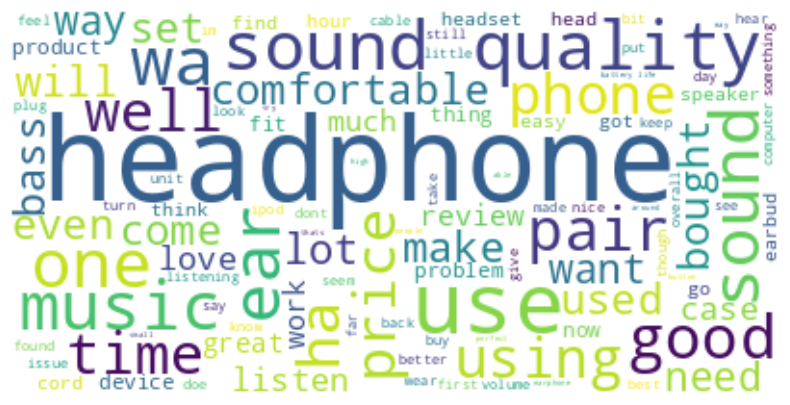

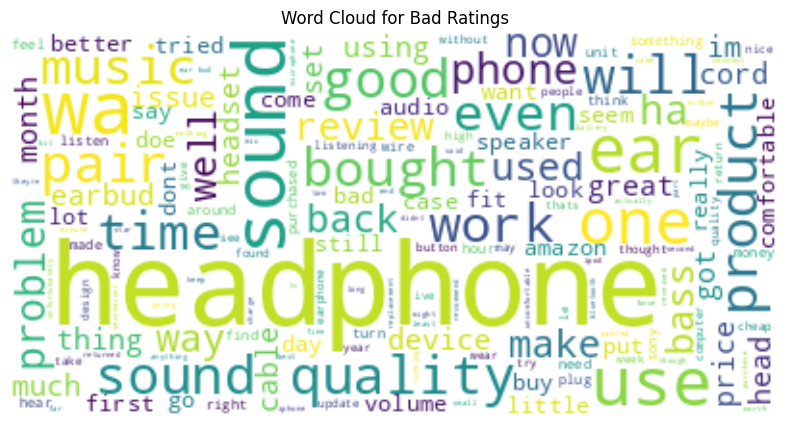

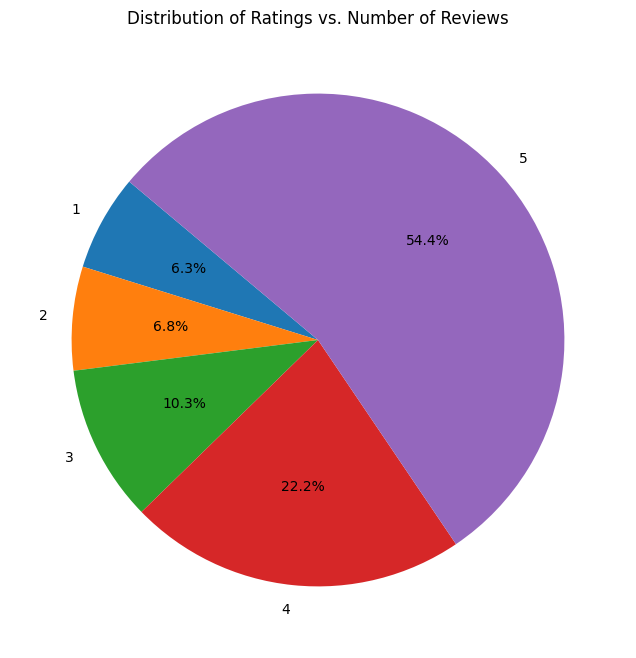

Year with maximum reviews: 2016
Year with the highest number of customers: 2016


In [6]:
import pandas as pd
import numpy as np
import gzip
import re
import unicodedata
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
import nltk
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import json



#a. Top 20 Most Reviewed Brands
# Assuming 'brand' column exists or you have extracted it from metadata
top_20_brands = final_df['brand'].value_counts().head(20)
print("Top 20 most reviewed brands:\n", top_20_brands)


#b. Top 20 Least Reviewed Brands
least_20_brands = final_df['brand'].value_counts().tail(20)
print("Top 20 least reviewed brands:\n", least_20_brands)

#c. Most Positively Reviewed Headphone
# Filter for products with a significant number of reviews, e.g., more than 50
filtered_reviews = final_df.groupby('asin').filter(lambda x: len(x) > 50)
# Calculate average rating for these products
average_ratings = filtered_reviews.groupby('asin')['overall'].mean()
most_positive_review = average_ratings.idxmax()
print(f"The most positively reviewed headphone ASIN: {most_positive_review}")

#d. Count of Ratings Over 5 Consecutive Years
# Convert 'reviewTime' to datetime and extract year
final_df['reviewYear'] = pd.to_datetime(final_df['reviewTime']).dt.year
# Count reviews per year for the last 5 years
review_counts = final_df['reviewYear'].value_counts().sort_index().tail(5)
print("Count of ratings over the last 5 consecutive years:\n", review_counts)

#e. Word Cloud for ‘Good’ and ‘Bad’ Ratings
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate a word cloud image for good ratings
good_reviews_text = ' '.join(review for review in final_df.loc[final_df['overall'] >= 3, 'preprocessed_reviewText'])
wordcloud_good = WordCloud(background_color="white").generate(good_reviews_text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud_good, interpolation='bilinear')
plt.axis("off")
plt.show()

# Generate a word cloud image for bad ratings
bad_reviews_text = ' '.join(review for review in final_df.loc[final_df['overall'] <= 2, 'preprocessed_reviewText'])
wordcloud_bad = WordCloud(background_color="white").generate(bad_reviews_text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud_bad, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for Bad Ratings")
plt.show()


#f. Pie Chart for Distribution of Ratings vs. No. of Reviews
ratings_distribution = final_df['overall'].value_counts().sort_index()
plt.figure(figsize=(8, 8))
plt.pie(ratings_distribution, labels=ratings_distribution.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Ratings vs. Number of Reviews')
plt.show()

#g. Year with Maximum Reviews
max_reviews_year = final_df['reviewYear'].value_counts().idxmax()
print(f"Year with maximum reviews: {max_reviews_year}")

#h. Year with the Highest Number of Customers
customers_per_year = final_df.groupby('reviewYear')['reviewerID'].nunique()
year_with_most_customers = customers_per_year.idxmax()
print(f"Year with the highest number of customers: {year_with_most_customers}")



# 7. Feature engineering

I chose TF-IDF here due to its effectiveness in capturing the importance of words in documents. TF-IDF helps mitigate the impact of frequently occurring words that might not be very informative about the content of the document.

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Assuming final_df['preprocessed_reviewText'] contains the preprocessed review texts
tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # Adjust max_features as needed
X = tfidf_vectorizer.fit_transform(final_df['preprocessed_reviewText'])


# 8. Rating class & 9. Splitting Data

In [8]:
def categorize_rating(rating):
    if rating > 3:
        return 'Good'
    elif rating == 3:
        return 'Average'
    else:
        return 'Bad'

final_df['RatingClass'] = final_df['overall'].apply(categorize_rating)


from sklearn.model_selection import train_test_split

# Defining the target variable
y = final_df['RatingClass']

# Splitting the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print(f"Train features shape: {X_train.shape}")
print(f"Test features shape: {X_test.shape}")
print(f"Train labels shape: {y_train.shape}")
print(f"Test labels shape: {y_test.shape}")

Train features shape: (139486, 1000)
Test features shape: (46496, 1000)
Train labels shape: (139486,)
Test labels shape: (46496,)


# 10. ML Models

In [ ]:
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC  # Import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from tqdm import tqdm

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "Linear SVM": LinearSVC(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier()
}

for name, model in tqdm(models.items(), desc="Training models"):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\nModel: {name}")
    print(classification_report(y_test, y_pred, digits=3, zero_division=0))




Training models:   0%|          | 0/5 [00:00<?, ?it/s]


Model: Logistic Regression


Training models:  20%|██        | 1/5 [00:36<02:25, 36.34s/it]

              precision    recall  f1-score   support

     Average      0.443     0.141     0.214      4722
         Bad      0.658     0.561     0.606      6040
        Good      0.863     0.963     0.910     35734

    accuracy                          0.827     46496
   macro avg      0.655     0.555     0.577     46496
weighted avg      0.794     0.827     0.800     46496


Model: Naive Bayes


Training models:  40%|████      | 2/5 [00:37<00:47, 15.90s/it]

              precision    recall  f1-score   support

     Average      0.000     0.000     0.000      4722
         Bad      0.803     0.036     0.070      6040
        Good      0.773     0.999     0.871     35734

    accuracy                          0.773     46496
   macro avg      0.525     0.345     0.314     46496
weighted avg      0.698     0.773     0.679     46496


Model: Linear SVM


Training models:  60%|██████    | 3/5 [00:52<00:30, 15.49s/it]

              precision    recall  f1-score   support

     Average      0.508     0.069     0.121      4722
         Bad      0.648     0.571     0.607      6040
        Good      0.855     0.970     0.909     35734

    accuracy                          0.827     46496
   macro avg      0.670     0.537     0.546     46496
weighted avg      0.793     0.827     0.790     46496


Model: Random Forest


Training models:  80%|████████  | 4/5 [24:10<09:20, 560.99s/it]

              precision    recall  f1-score   support

     Average      0.963     0.202     0.334      4722
         Bad      0.871     0.333     0.481      6040
        Good      0.824     0.996     0.902     35734

    accuracy                          0.829     46496
   macro avg      0.886     0.510     0.572     46496
weighted avg      0.844     0.829     0.790     46496


Model: Gradient Boosting


Training models: 100%|██████████| 5/5 [52:05<00:00, 625.13s/it]

              precision    recall  f1-score   support

     Average      0.468     0.036     0.067      4722
         Bad      0.718     0.253     0.374      6040
        Good      0.804     0.990     0.888     35734

    accuracy                          0.798     46496
   macro avg      0.663     0.426     0.443     46496
weighted avg      0.759     0.798     0.738     46496



In [ ]:
# Saving the models
from joblib import dump
import os

# Specify the directory to save your models
model_save_dir = '/content/drive/MyDrive/IR/ass3/models'
os.makedirs(model_save_dir, exist_ok=True)  # Create the directory if it doesn't exist

# Loop through each model and save it to disk
for name, model in models.items():
    model_path = os.path.join(model_save_dir, f'{name.replace(" ", "_")}.joblib')
    dump(model, model_path)
    print(f"Saved {name} to {model_path}")

Saved Logistic Regression to /content/drive/MyDrive/IR/ass3/models/Logistic_Regression.joblib
Saved Naive Bayes to /content/drive/MyDrive/IR/ass3/models/Naive_Bayes.joblib
Saved Linear SVM to /content/drive/MyDrive/IR/ass3/models/Linear_SVM.joblib
Saved Random Forest to /content/drive/MyDrive/IR/ass3/models/Random_Forest.joblib
Saved Gradient Boosting to /content/drive/MyDrive/IR/ass3/models/Gradient_Boosting.joblib


In [7]:
# Loading the models

from joblib import load
import os

# Directory where models are saved
model_save_dir = '/content/drive/MyDrive/IR/ass3/models'

# Assuming you know the model names or can infer them from the filenames
model_names = ["Logistic Regression", "Naive Bayes", "Linear SVM", "Random Forest", "Gradient Boosting"]

# Dictionary to hold the loaded models
loaded_models = {}

# Loop through each model name, construct the filename, and load the model
for name in model_names:
    model_file = os.path.join(model_save_dir, f'{name.replace(" ", "_")}.joblib')
    loaded_models[name] = load(model_file)
    print(f"Loaded {name} from {model_file}")


Loaded Logistic Regression from /content/drive/MyDrive/IR/ass3/models/Logistic_Regression.joblib
Loaded Naive Bayes from /content/drive/MyDrive/IR/ass3/models/Naive_Bayes.joblib
Loaded Linear SVM from /content/drive/MyDrive/IR/ass3/models/Linear_SVM.joblib
Loaded Random Forest from /content/drive/MyDrive/IR/ass3/models/Random_Forest.joblib
Loaded Gradient Boosting from /content/drive/MyDrive/IR/ass3/models/Gradient_Boosting.joblib


# 11. Collaborative Filtering :

In [10]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

# Sample DataFrame
np.random.seed(42)
final_df = pd.DataFrame({
    'reviewerID': np.random.randint(1, 100, 1000),
    'asin': np.random.randint(1, 20, 1000),
    'overall': np.random.randint(1, 6, 1000)
})

# Creating user-item rating matrix
user_item_matrix = final_df.pivot_table(index='reviewerID', columns='asin', values='overall').fillna(0)


# Normalize the ratings
scaler = MinMaxScaler()
user_item_matrix_scaled = pd.DataFrame(scaler.fit_transform(user_item_matrix), index=user_item_matrix.index, columns=user_item_matrix.columns)
# Transpose the user-item matrix to get the item-user matrix
item_user_matrix_scaled = user_item_matrix_scaled.T

In [11]:
def cosine_similarity(matrix):
    sim_matrix = np.dot(matrix, matrix.T)
    norms = np.array([np.sqrt(np.diagonal(sim_matrix))])
    return (sim_matrix / norms / norms.T)


In [12]:
def find_nearest_neighbors(user_index, top_n, similarity_matrix, index_mapping):
    mapped_index = index_mapping.get(user_index, -1)
    if mapped_index == -1:
        return np.array([])
    user_similarities = similarity_matrix[mapped_index]
    nearest_neighbor_indices = np.argsort(user_similarities)[::-1][:top_n]  # Get top N without including the user itself
    return nearest_neighbor_indices

def predict_rating(neighbors_indices, similarity_matrix, user_item_matrix, index_mapping):
    if len(neighbors_indices) == 0:
        return np.zeros(user_item_matrix.shape[1])  # Return zero ratings if no neighbors
    neighbor_similarities = [similarity_matrix[index_mapping.get(idx)][neighbors_indices] for idx in index_mapping.values()]
    neighbor_ratings = user_item_matrix.iloc[neighbors_indices].values
    predicted_ratings = np.average(neighbor_ratings, axis=0, weights=neighbor_similarities)
    return predicted_ratings

def calculate_mae(predicted_matrix, actual_matrix):
    diff = predicted_matrix - actual_matrix
    mae = np.abs(diff).mean()
    return mae


In [13]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler


# Define the KFold cross-validator
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize a dictionary to store MAE scores for different numbers of neighbors
avg_mae_scores = {}

# Define the functions find_nearest_neighbors and predict_rating
def find_nearest_neighbors(user_index, top_n, similarity_matrix, index_mapping):
    # Assuming similarity_matrix is a square matrix with users both as rows and columns
    user_similarities = similarity_matrix[index_mapping[user_index]]
    # Get the indices of the top N similar users, excluding the user itself
    top_indices = np.argsort(user_similarities)[-top_n-1:-1]
    return top_indices

def predict_rating(neighbors_indices, similarity_matrix, user_item_matrix, index_mapping):
    # Simplified prediction: average ratings of the top N neighbors
    ratings_sum = np.zeros(user_item_matrix.shape[1])  # Initialize a sum array
    for neighbor_idx in neighbors_indices:
        neighbor_ratings = user_item_matrix.iloc[neighbor_idx].values
        ratings_sum += neighbor_ratings
    predicted_ratings = ratings_sum / len(neighbors_indices)
    return predicted_ratings

# Iterate over different numbers of nearest neighbors
for n_neighbors in [10, 20, 30, 40, 50]:
    fold_maes = []  # List to store MAE for each fold

    for train_idx, test_idx in kf.split(user_item_matrix_scaled):
        # Extract training and testing matrices
        train_matrix = user_item_matrix_scaled.iloc[train_idx]
        test_matrix = user_item_matrix_scaled.iloc[test_idx]

        # Generate the similarity matrix for the training subset
        train_sim_matrix = cosine_similarity(train_matrix)

        # Map original indices to the new indices in train_matrix
        index_mapping = {orig_idx: i for i, orig_idx in enumerate(train_idx)}

        fold_predictions = []  # List to store predictions for each user in the test set
        for orig_idx in test_idx:
            if orig_idx in index_mapping:  # Ensure the user is in the mapping
                neighbors_indices = find_nearest_neighbors(orig_idx, n_neighbors, train_sim_matrix, index_mapping)
                predicted_ratings = predict_rating(neighbors_indices, train_sim_matrix, train_matrix, index_mapping)
                fold_predictions.append(predicted_ratings)
            else:
                # Append zeros if the user was not found in the training set
                fold_predictions.append(np.zeros(train_matrix.shape[1]))

        # Calculate MAE for the current fold
        predicted_matrix = np.array(fold_predictions)
        actual_matrix = test_matrix.values
        mae = mean_absolute_error(actual_matrix, predicted_matrix)
        fold_maes.append(mae)

    # Store the average MAE for the current number of neighbors
    avg_mae_scores[n_neighbors] = np.mean(fold_maes)

print("Average MAE Scores for User-User system:", avg_mae_scores)


Average MAE Scores for User-User system: {10: 0.2465540166204986, 20: 0.2465540166204986, 30: 0.2465540166204986, 40: 0.2465540166204986, 50: 0.2465540166204986}


In [14]:
def find_nearest_items(item_index, top_n, similarity_matrix):
    item_similarities = similarity_matrix[item_index]
    top_indices = np.argsort(item_similarities)[-top_n-1:-1]  # Exclude the item itself
    return top_indices

def predict_item_rating(item_index, neighbors_indices, item_user_matrix):
    neighbor_ratings = item_user_matrix.iloc[neighbors_indices]
    predicted_rating = neighbor_ratings.mean(axis=0)
    return predicted_rating
from sklearn.metrics.pairwise import cosine_similarity

# Compute cosine similarity across items
item_sim_matrix = cosine_similarity(item_user_matrix_scaled)
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

kf = KFold(n_splits=5, shuffle=True, random_state=42)
avg_mae_scores_item_item = {n: [] for n in [10, 20, 30, 40, 50]}

for n_neighbors in [10, 20, 30, 40, 50]:
    fold_maes = []
    for train_idx, test_idx in kf.split(item_user_matrix_scaled):
        # Create training and testing matrices
        train_matrix, test_matrix = item_user_matrix_scaled.iloc[train_idx], item_user_matrix_scaled.iloc[test_idx]

        # Generate similarity matrix for items in the training subset
        train_sim_matrix = cosine_similarity(train_matrix)

        # Predict ratings for items in the test set
        fold_predictions = []
        for item_index in range(len(test_matrix)):
            neighbors_indices = find_nearest_items(item_index, n_neighbors, train_sim_matrix)
            predicted_ratings = predict_item_rating(item_index, neighbors_indices, train_matrix)
            fold_predictions.append(predicted_ratings.values)

        predicted_matrix = np.array(fold_predictions)
        actual_matrix = test_matrix.values
        mae = mean_absolute_error(actual_matrix, predicted_matrix)
        fold_maes.append(mae)

    avg_mae_scores_item_item[n_neighbors].append(np.mean(fold_maes))

# Calculate the average MAE for each number of neighbors
for n in avg_mae_scores_item_item:
    avg_mae_scores_item_item[n] = np.mean(avg_mae_scores_item_item[n])

print("Average MAE Scores for Item-Item System:", avg_mae_scores_item_item)


Average MAE Scores for Item-Item System: {10: 0.308425645342312, 20: 0.3036878440489552, 30: 0.3036878440489552, 40: 0.3036878440489552, 50: 0.3036878440489552}


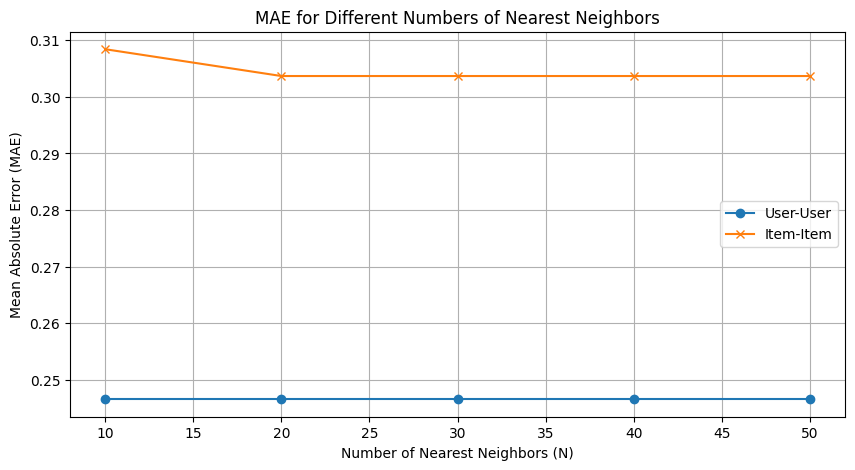

In [15]:
import matplotlib.pyplot as plt

# Assuming avg_mae_scores for user-user and avg_mae_scores_item_item for item-item are defined
plt.figure(figsize=(10, 5))
plt.plot(list(avg_mae_scores.keys()), list(avg_mae_scores.values()), label='User-User', marker='o')
plt.plot(list(avg_mae_scores_item_item.keys()), list(avg_mae_scores_item_item.values()), label='Item-Item', marker='x')
plt.xlabel('Number of Nearest Neighbors (N)')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('MAE for Different Numbers of Nearest Neighbors')
plt.legend()
plt.grid(True)
plt.show()


# 12. TOP 10 products by User Sum Ratings

In [27]:
# Step 1: Calculate the sum of ratings for each product
product_sum_ratings = final_df_copy.groupby(['asin', 'brand', 'title'])['overall'].sum().reset_index(name='sum_ratings')

# Step 2: Sort the products by their sum ratings in descending order and select the top 10
top_10_products = product_sum_ratings.sort_values(by='sum_ratings', ascending=False).head(10)

print("Top 10 Products by User Sum Ratings with Brand and Product Name:")
print(top_10_products[['asin', 'brand', 'title', 'sum_ratings']])


Top 10 Products by User Sum Ratings with Brand and Product Name:
            asin           brand  \
737   B0002H02ZY            Sony   
54    B00001WRSJ            Sony   
41    B00001P4ZH            Koss   
80    B00004T8R2       Panasonic   
5493  B004WODP20            Sony   
8871  B00BN0N0LW            Sony   
207   B000065BPB      Sennheiser   
343   B00007E7C8  Audio-Technica   
2283  B000ULAP4U  Audio-Technica   
4559  B003LPTAYI      Sennheiser   

                                                  title  sum_ratings  
737   Sony MDR7506 Professional Large Diaphragm Head...         7600  
54    Sony MDRV6 Studio Monitor Headphones with CCAW...         6292  
41    Koss Porta Pro On Ear Headphones with Case, Bl...         6206  
80    Panasonic Headphones On-Ear Lightweight with X...         5690  
5493                   Sony MDRZX100 Headphones (Black)         5277  
8871   Sony MDRZX100 ZX Series Stereo Headphones (Blue)         5246  
207          Sennheiser HD280PRO Headphon